In [1]:
import torch
import torch.nn as nn
import torch.optim
import torch.distributed
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.multiprocessing
import tqdm
import os
from collections import OrderedDict
import time
import logging
import json
import random
import numpy as np

from utils import img2mse, mse2psnr, img_HWC2CHW, colorize, TINY_NUMBER
from ddp_train_nerf import config_parser, setup_logger, setup, cleanup, create_nerf, intersect_sphere, sample_pdf 
from data_loader_split import load_data_split
from ddp_model import NerfNetWithAutoExpo
from ddp_test_nerf import ddp_test_nerf
from nerf_sample_ray_split import RaySamplerSingleImage

In [2]:
logger = logging.getLogger(__package__)
parser = config_parser()
args = parser.parse_args("--expname dr-johnson --config configs/Dr-Johnson-nerfpp.txt")
logger.info(parser.format_values())

In [3]:
def create_model(args):
    models = OrderedDict()
    models['cascade_level'] = args.cascade_level
    models['cascade_samples'] = [int(x.strip()) for x in args.cascade_samples.split(',')]
    for m in range(models['cascade_level']):
        img_names = None
        net = NerfNetWithAutoExpo(args, optim_autoexpo=args.optim_autoexpo, img_names=img_names)
        models['net_{}'.format(m)] = net
    start = -1

    ###### load pretrained weights; each process should do this
    if (args.ckpt_path is not None) and (os.path.isfile(args.ckpt_path)):
        ckpts = [args.ckpt_path]
    else:
        ckpts = [os.path.join(args.basedir, args.expname, f)
                 for f in sorted(os.listdir(os.path.join(args.basedir, args.expname))) if f.endswith('.pth')]
    def path2iter(path):
        tmp = os.path.basename(path)[:-4]
        idx = tmp.rfind('_')
        return int(tmp[idx + 1:])
    ckpts = sorted(ckpts, key=path2iter)
    logger.info('Found ckpts: {}'.format(ckpts))
    if len(ckpts) > 0 and not args.no_reload:
        #fpath = ckpts[1]
        fpath = ckpts[-1]
        logger.info('Reloading from: {}'.format(fpath))
        start = path2iter(fpath)
        to_load = torch.load(fpath)
        for m in range(models['cascade_level']):
            for name in ['net_{}'.format(m)]:
                models[name].load_state_dict({k.replace("module.", ""):item for k,item in to_load[name].items()})

    return start, models

In [4]:
start, models = create_model(args)
models["net_0"] = models["net_0"].to(0)
models["net_1"] = models["net_1"].to(0)
ray_samplers = load_data_split(args.datadir, args.scene, split="train", 
                               try_load_min_depth=args.load_min_depth, shuffle=False)

## Select image to reconstruct

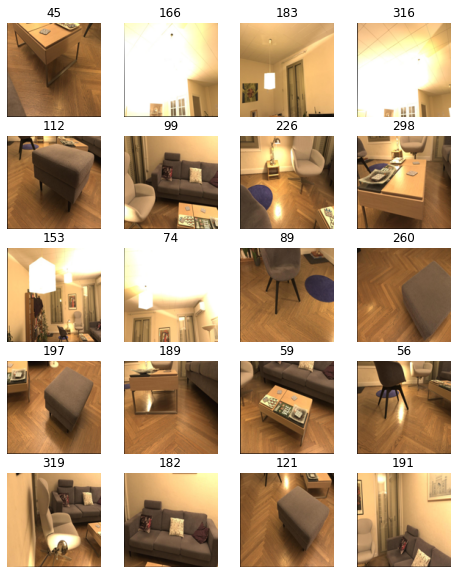

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

columns = 4
rows = 5
fig=plt.figure(figsize=(columns*2, rows*2))
ax = []
for i in range(1, columns*rows +1):
    img_idx = np.random.randint(len(ray_samplers))
    img = Image.open(ray_samplers[img_idx].img_path).resize((128,128))
    ax.append( fig.add_subplot(rows, columns, i))
    #ax[-1].set_title(os.path.basename(ray_samplers[img_idx].img_path))  # set title
    ax[-1].set_title(str(img_idx))  # set title
    plt.imshow(img)
    plt.axis('off')
plt.show()

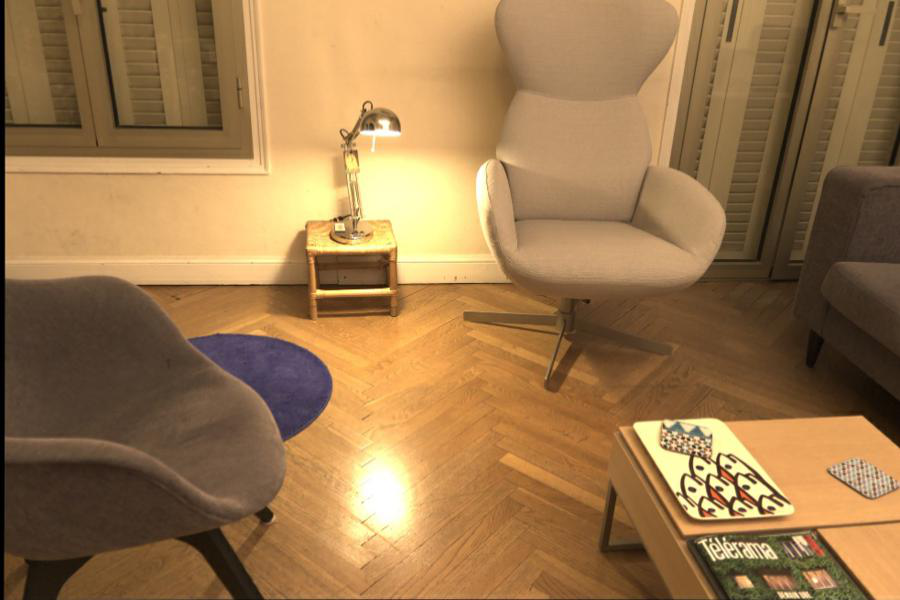

In [6]:
img_idx = 192
img = Image.open(ray_samplers[img_idx].img_path)
W, H = img.size
img

In [7]:
def render_single_image(models, ray_sampler, chunk_size):
    ##### parallel rendering of a single image
    #rank
    #world_size
    ray_batch = ray_sampler.get_all()
    
    if (ray_batch['ray_d'].shape[0] )  != ray_batch['ray_d'].shape[0]:
        raise Exception('Number of pixels in the image is not divisible by the number of GPUs!\n\t# pixels: {}\n\t# GPUs: {}'.format(ray_batch['ray_d'].shape[0],
                                                                                                                                     world_size))
    
    rank_split_sizes = [ray_batch['ray_d'].shape[0],]
    
    for key in ray_batch:
        if torch.is_tensor(ray_batch[key]):
            ray_batch[key] = torch.split(ray_batch[key], rank_split_sizes)[0].to(0)

    # split into chunks and render inside each process
    ray_batch_split = OrderedDict()
    for key in ray_batch:
        if torch.is_tensor(ray_batch[key]):
            ray_batch_split[key] = torch.split(ray_batch[key], chunk_size)

    # forward and backward
    ret_merge_chunk = [OrderedDict() for _ in range(models['cascade_level'])]
    for s in tqdm.tqdm(range(len(ray_batch_split['ray_d']))):
        ray_o = ray_batch_split['ray_o'][s]
        ray_d = ray_batch_split['ray_d'][s]
        min_depth = ray_batch_split['min_depth'][s]

        dots_sh = list(ray_d.shape[:-1])
        for m in range(models['cascade_level']):
            net = models['net_{}'.format(m)]
            # sample depths
            N_samples = models['cascade_samples'][m]
            if m == 0:
                # foreground depth
                fg_far_depth = intersect_sphere(ray_o, ray_d)  # [...,]
                fg_near_depth = min_depth  # [..., ]
                step = (fg_far_depth - fg_near_depth) / (N_samples - 1)
                fg_depth = torch.stack([fg_near_depth + i * step for i in range(N_samples)], dim=-1)  # [..., N_samples]

                # background depth
                bg_depth = torch.linspace(0., 1., N_samples).view(
                    [1, ] * len(dots_sh) + [N_samples,]).expand(dots_sh + [N_samples,]).to(0)

                # delete unused memory
                del fg_near_depth
                del step
                torch.cuda.empty_cache()
            else:
                # sample pdf and concat with earlier samples
                fg_weights = ret['fg_weights'].clone().detach()
                fg_depth_mid = .5 * (fg_depth[..., 1:] + fg_depth[..., :-1])    # [..., N_samples-1]
                fg_weights = fg_weights[..., 1:-1]                              # [..., N_samples-2]
                fg_depth_samples = sample_pdf(bins=fg_depth_mid, weights=fg_weights,
                                              N_samples=N_samples, det=True)    # [..., N_samples]
                fg_depth, _ = torch.sort(torch.cat((fg_depth, fg_depth_samples), dim=-1))

                # sample pdf and concat with earlier samples
                bg_weights = ret['bg_weights'].clone().detach()
                bg_depth_mid = .5 * (bg_depth[..., 1:] + bg_depth[..., :-1])
                bg_weights = bg_weights[..., 1:-1]                              # [..., N_samples-2]
                bg_depth_samples = sample_pdf(bins=bg_depth_mid, weights=bg_weights,
                                              N_samples=N_samples, det=True)    # [..., N_samples]
                bg_depth, _ = torch.sort(torch.cat((bg_depth, bg_depth_samples), dim=-1))

                # delete unused memory
                del fg_weights
                del fg_depth_mid
                del fg_depth_samples
                del bg_weights
                del bg_depth_mid
                del bg_depth_samples
                torch.cuda.empty_cache()

            with torch.no_grad():
                ret = net(ray_o, ray_d, fg_far_depth, fg_depth, bg_depth, top_depth=10)

            for key in ret:
                if key not in ['fg_weights', 'bg_weights']:
                    if torch.is_tensor(ret[key]):
                        if key not in ret_merge_chunk[m]:
                            ret_merge_chunk[m][key] = [ret[key].cpu(), ]
                        else:
                            ret_merge_chunk[m][key].append(ret[key].cpu())

                        ret[key] = None

            # clean unused memory
            torch.cuda.empty_cache()

    # merge results from different chunks
    for m in range(len(ret_merge_chunk)):
        for key in ret_merge_chunk[m]:
            ret_merge_chunk[m][key] = torch.cat(ret_merge_chunk[m][key], dim=0)

    return ret_merge_chunk

In [8]:
ret_merge_chunk = render_single_image(models, ray_samplers[img_idx], args.chunk_size)

100%|██████████| 66/66 [02:44<00:00,  2.50s/it]


In [11]:
len(ray_samplers)

322

In [10]:
start

875000

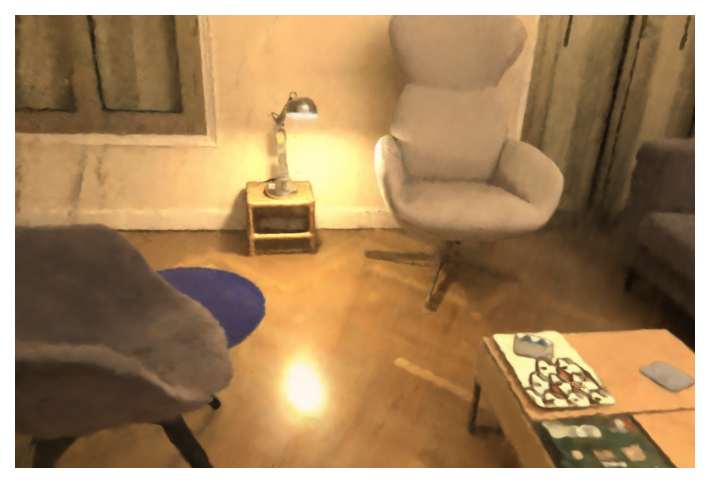

In [9]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

generated = ret_merge_chunk[1]["rgb"]
generated = generated.reshape((ray_samplers[img_idx].H,ray_samplers[img_idx].W,3))
plt.axis('off')
plt.imshow(generated)

In [93]:
def save_image(rgb_tensor, file_name):
    np_im = np.array(rgb_tensor.reshape((H,W,3)))
    im = Image.fromarray((255*np_im).astype(np.ubyte))
    im.save(file_name)
save_image(ret_merge_chunk[0]["rgb"], "img/coarse-reconstruction.png")
save_image(ret_merge_chunk[1]["rgb"], "img/fine-reconstruction.png")
save_image(ret_merge_chunk[0]["bg_rgb"], "img/fine-bg.png")
save_image(ret_merge_chunk[1]["bg_rgb"], "img/coarse-bg.png")

## find camera pos

In [20]:
def copy_ray_sampler(ray_sampler):
    return RaySamplerSingleImage(H=ray_sampler.H_orig, W=ray_sampler.W_orig, 
                          intrinsics=ray_sampler.intrinsics_orig, 
                          c2w=ray_sampler.c2w_mat,
                          img_path=ray_sampler.img_path,
                          mask_path=ray_sampler.mask_path,
                          min_depth_path=ray_sampler.min_depth_path,
                          max_depth=ray_sampler.max_depth)
ray_copy = copy_ray_sampler(ray_samplers[img_idx])
ray_copy.set_resolution_level(4)

In [21]:
mat = ray_samplers[img_idx].c2w_mat.copy()
mat

array([[ 0.8372427 ,  0.30885762, -0.45125553,  0.00856913],
       [-0.418349  ,  0.8932022 , -0.16484538,  0.05908192],
       [ 0.35214868,  0.3267979 ,  0.8770373 , -0.05098931],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [22]:
mat[:3,:3] = np.eye(3)
mat

array([[ 1.        ,  0.        ,  0.        ,  0.00856913],
       [ 0.        ,  1.        ,  0.        ,  0.05908192],
       [ 0.        ,  0.        ,  1.        , -0.05098931],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [23]:
mat = np.array([[ 0.8372427 ,  0.30885762, -0.45125553,  0.00856913],
       [-0.418349  ,  0.8932022 , -0.16484538,  -0.03],
       [ 0.35214868,  0.3267979 ,  0.8770373 , 0.1],
       [ 0.        ,  0.        ,  0.        ,  1.        ]], dtype=np.float32)

100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


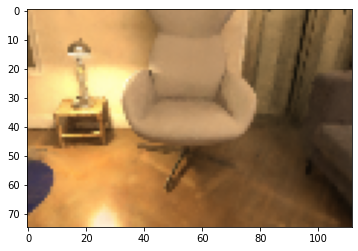

In [24]:
ray_copy = copy_ray_sampler(ray_samplers[img_idx])
ray_copy.c2w_mat = mat
ray_copy.set_resolution_level(8)
ret_merge_chunk = render_single_image(models, ray_copy, args.chunk_size)
generated = ret_merge_chunk[1]["rgb"]
generated = generated.reshape((ray_copy.H,ray_copy.W,3))
plt.imshow(generated)

In [26]:
ray_copy.set_resolution_level(1)
ret_merge_chunk = render_single_image(models, ray_copy, args.chunk_size)

100%|██████████| 66/66 [02:38<00:00,  2.40s/it]


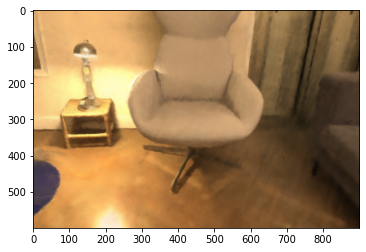

In [27]:
generated = ret_merge_chunk[1]["rgb"]
generated = generated.reshape((ray_copy.H,ray_copy.W,3))
plt.imshow(generated)

## Analysis

In [82]:
rays = np.random.choice(len(ret_merge_chunk[0]["fg_topk_weight_sum"]), 600*900, replace=False)

In [83]:
cascade = 1

In [84]:
ret_merge_chunk[cascade]["fg_topk_weight_sum"][rays]

tensor([1.0001, 0.9996, 1.0001,  ..., 1.0000, 1.0001, 0.3986])

In [85]:
torch.sum(ret_merge_chunk[cascade]["fg_topk_weights"][rays], dim=-1)

tensor([0.3288, 0.6633, 0.8360,  ..., 0.1968, 0.3391, 0.1149])

In [86]:
(torch.sum(ret_merge_chunk[cascade]["fg_topk_weights"][rays], dim=-1) / 
 ret_merge_chunk[cascade]["fg_topk_weight_sum"][rays]).mean()

tensor(0.3731)

In [87]:
(ret_merge_chunk[cascade]["fg_topk_weights"][rays][:,0] / 
 ret_merge_chunk[cascade]["fg_topk_weight_sum"][rays]).mean()

tensor(0.0777)

## Analyse depth 

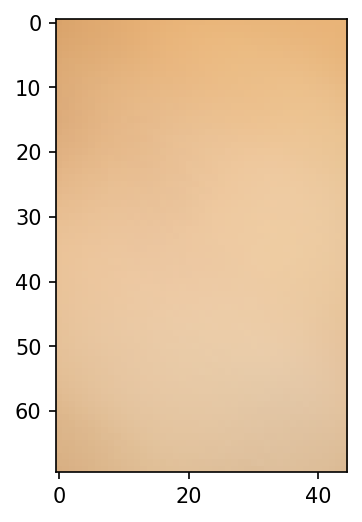

In [10]:
i_min=450
i_max=520
j_min=360
j_max=405
generated = ret_merge_chunk[1]["rgb"]
generated = generated.reshape((H,W,3))
plt.imshow(generated[i_min:i_max,j_min:j_max])

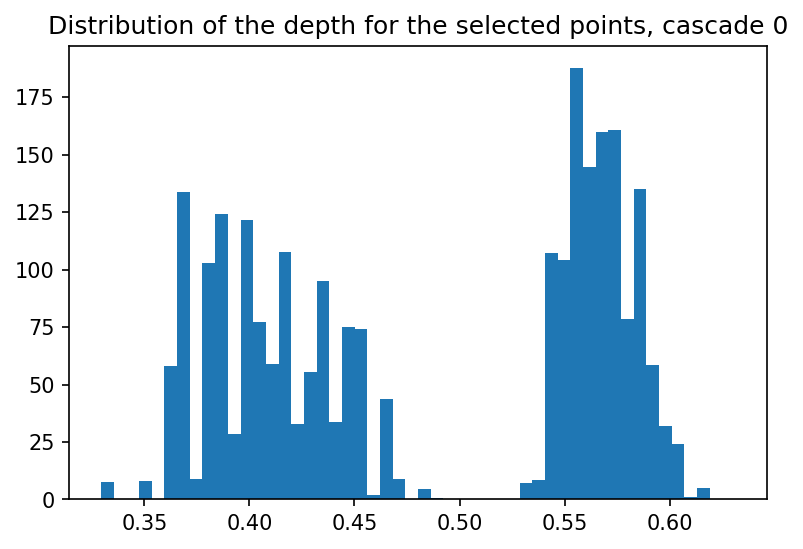

In [13]:
K= 10
cascade = 0
depth = ret_merge_chunk[cascade]["fg_topk_depth"].reshape((H,W,K))[i_min:i_max,j_min:j_max].reshape((-1,))
weights = ret_merge_chunk[cascade]["fg_topk_weights"].reshape((H,W,K))[i_min:i_max,j_min:j_max].reshape((-1,))
plt.hist(np.array(depth), bins=50, weights=np.array(weights))
plt.title(f'Distribution of the depth for the selected points, cascade {cascade}')
pass

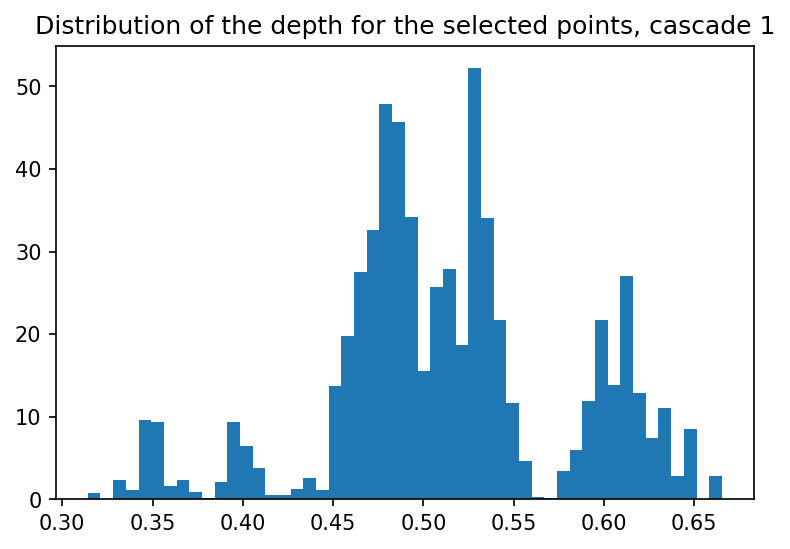

In [14]:
cascade = 1
depth = ret_merge_chunk[cascade]["fg_topk_depth"].reshape((H,W,K))[i_min:i_max,j_min:j_max].reshape((-1,))
weights = ret_merge_chunk[cascade]["fg_topk_weights"].reshape((H,W,K))[i_min:i_max,j_min:j_max].reshape((-1,))
plt.hist(np.array(depth), bins=50, weights=np.array(weights))
plt.title(f'Distribution of the depth for the selected points, cascade {cascade}')
pass

## Save results

In [15]:
from plyfile import PlyData, PlyElement


def format_np_array_rgb(array):
    dtype=[('red', 'u1'), ('green', 'u1'),('blue', 'u1')]
    return np.array([tuple(p * 255) for p in array], dtype=dtype)

def format_np_array(array):
    dtype=[('x', 'f4'), ('y', 'f4'),('z', 'f4')]
    return np.array([tuple(p) for p in array], dtype=dtype)

def format_np_array_scalar(array, name="scalar"):
    dtype=[(name, 'f4')]
    return np.array([(s,) for s in array], dtype=dtype)

def export_ply(file_name, vertices, normals=None, scalar=None, rgb=None):
    points = PlyElement.describe(format_np_array(vertices), 'points')
    elements = [points]
    if normals is not None: 
        normals = PlyElement.describe(format_np_array(normals), 'normals')
        elements.append(normals)    
    if rgb is not None: 
        normals = PlyElement.describe(format_np_array_rgb(rgb), 'rgb')
        elements.append(normals)
    if scalar is not None: 
        scalar = PlyElement.describe(format_np_array_scalar(scalar), 'scalar')
        elements.append(scalar)
    
    PlyData(elements).write(file_name)


In [18]:
def save_ply(ret_merge_chunk, name, args):
    for cascade in range(args.cascade_level):
        for k in [1, ret_merge_chunk[cascade]["fg_topk_weights"].shape[-1]]:
            pos = np.array(ret_merge_chunk[cascade]["fg_topk_pos"][:,:k].reshape((-1,3)))
            rgb = np.array(ret_merge_chunk[cascade]["fg_topk_rgb"][:,:k].reshape((-1,3)))
            weights = np.array(ret_merge_chunk[cascade]["fg_topk_weights"].reshape((-1)))
            idxs = np.random.choice(len(pos), len(pos)//k, replace=False)
            export_ply(f"ply_output/fg_top{k}_{cascade}_{name}_view2.ply", 
                       pos[idxs], rgb=rgb[idxs], scalar=weights[idxs])

In [19]:
save_ply(ret_merge_chunk, os.path.basename(ray_samplers[img_idx].img_path).split(".")[0], args)

In [28]:
save_ply(ret_merge_chunk, 'custom_view', args)

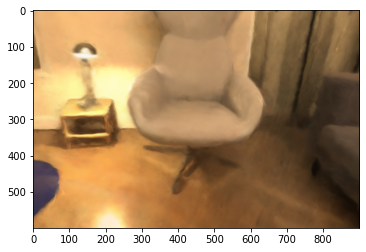

In [117]:
generated = ret_merge_chunk[cascade]["rgb"]
generated = generated.reshape((H,W,3))
plt.imshow(generated)

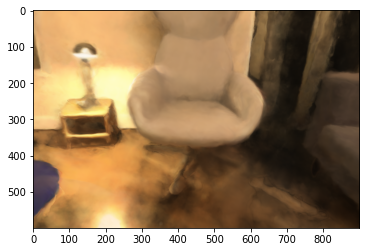

In [118]:
generated = ret_merge_chunk[cascade]["fg_rgb"]
generated = generated.reshape((H,W,3))
plt.imshow(generated)